In [1]:
import pennylane as qml
from pennylane import numpy as np

import matplotlib.pyplot as plt

loss_limits = (-0.1, 1.3)

title_fontsize = 18
label_fontsize = 18 
tick_fontsize = 15
colorbar_fontsize = 17
legend_fontsize = 16

In [2]:
n_qubits = 5

dev1 = qml.device("default.qubit", wires=n_qubits)

In [3]:
def get_ising_hamiltonian(n_qubits, transverse_field_coefficient):
    
    
    obs = [qml.PauliZ(i) @ qml.PauliZ(i+1) for i in range((n_qubits-1))]
    coeffs = [1.0 for i in range((n_qubits-1))]
    z_term = qml.Hamiltonian(coeffs, obs)

    obs = [qml.PauliX(i) for i in range((n_qubits-1))]
    coeffs = [transverse_field_coefficient for i in range((n_qubits-1))]
    transverse_field_term = qml.Hamiltonian(coeffs, obs)

    ising_hamiltonian = transverse_field_term + z_term

    # if n_qubits < 5:

    #     n_eigenvalues = 2**(n_qubits-1)

    # else:
    #     n_eigenvalues = 30

    # energies = qml.eigvals(ising_hamiltonian, k=n_eigenvalues, which='SR')

    return ising_hamiltonian #, energies

In [9]:
def perceptron_circuit(param_list, n_qubits, depth):

    gate_offset = 1 * n_qubits # number of parameters per operator times number of operators
    
    for d in range(depth):

        depth_offset = d*gate_offset*4
        # print(depth_offset)

        # print("new layer with depth offset ", depth_offset)

        for i in range(n_qubits):
            theta = param_list[i + gate_offset*0 + depth_offset]
            # print("RX layer ", param_list[i + gate_offset*0 + depth_offset])
            # gate = RX(i, param_list[i + gate_offset*0 + depth_offset])
            qml.RX(theta, wires=i)

        for i in range(n_qubits):
            theta = param_list[i + gate_offset*1 + depth_offset]
            # print("RZ layer ", param_list[i + gate_offset*1 + depth_offset])
            # gate = RZ(i, param_list[i + gate_offset*1 + depth_offset])
            qml.RZ(theta, wires = i)

        qml.Barrier(only_visual=True)

        for i in range(n_qubits-1):
            qml.CZ(wires = [i, n_qubits-1])

        qml.Barrier(only_visual=True)

        for i in range(n_qubits):
            theta = param_list[i + gate_offset*2 + depth_offset]
            # print("RX layer ", param_list[i + gate_offset*2 + depth_offset])
            # gate = RX(i, param_list[i + gate_offset*2 + depth_offset])
            qml.RX(theta, wires = i)

        for i in range(n_qubits):
            theta = param_list[i+ gate_offset*3 + depth_offset]
            # print("RZ layer ", param_list[i + gate_offset*3 + depth_offset])
            # gate = RZ(i, param_list[i+ gate_offset*3 + depth_offset])
            qml.RZ(theta, wires = i)



In [7]:

transverse_field_coefficient = 0.1

depth = 5


@qml.qnode(dev1, interface="autograd")
def loss_function(param_list):

    perceptron_circuit(param_list, n_qubits, depth)
    
    ising_hamiltonian = get_ising_hamiltonian(n_qubits, transverse_field_coefficient)

    return qml.expval(ising_hamiltonian)

    

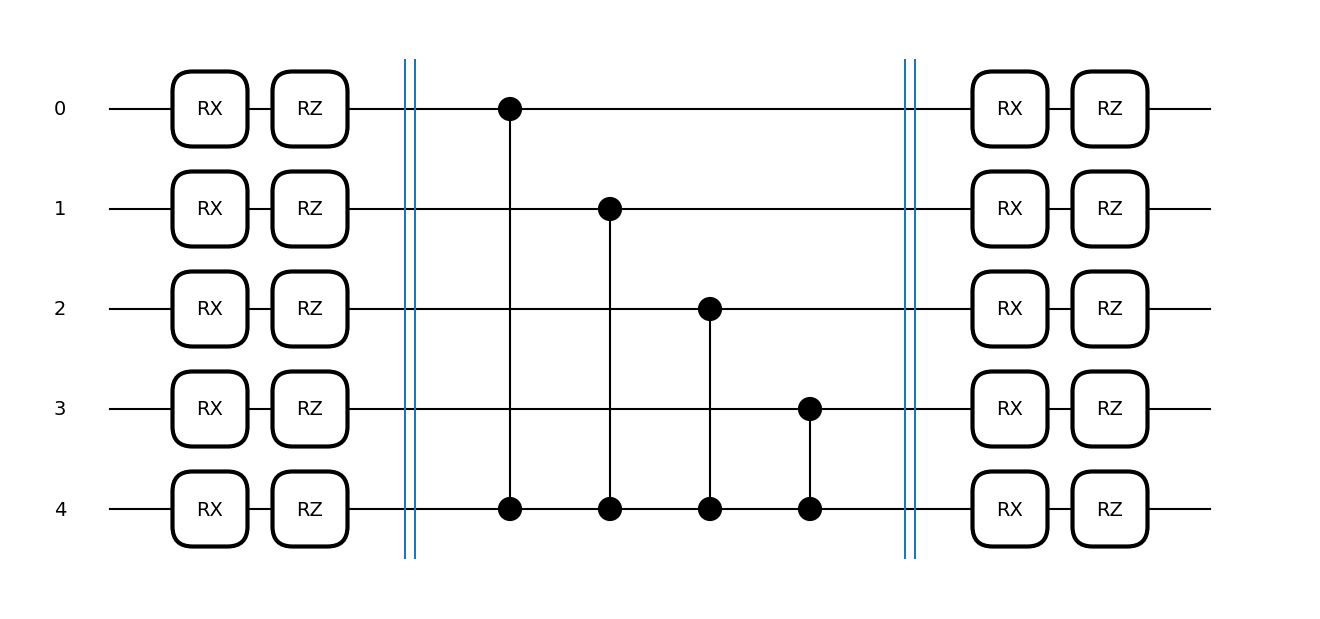

In [10]:
transverse_field_coefficient = 0.1

depth = 1
gates_per_layer = n_qubits
param_dim = gates_per_layer*4*depth
initial_parameters = np.random.random(param_dim)*1e-1


fig, ax = qml.draw_mpl(perceptron_circuit)(initial_parameters, n_qubits, depth)

# print(qml.draw(perceptron_circuit)(initial_parameters, n_qubits, depth))

In [8]:
# testing out the loss function

loss_function(initial_parameters)


tensor(3.08333346, requires_grad=True)

In [9]:
# Defining a simple gradient descent optimizer

def gradient_descent_optimizer(initial_parameters, 
                               loss_function,
                               n_iters,
                               learning_rate=0.2):
    opt = qml.GradientDescentOptimizer(stepsize=learning_rate)
    parameter_trajectory = [initial_parameters, ]
    losses = [loss_function(initial_parameters), ]
    params = initial_parameters

    for i in range(n_iters):
        params, prev_cost = opt.step_and_cost(loss_function, params)
        cost = loss_function(params) # this is squandering executions ...
        parameter_trajectory += [params, ]
        losses += [cost, ]

    return parameter_trajectory, losses

/Users/jorgegarciaponce/Research/Yelin/Perceptron/CumulantNODEs/perceptron_venv/lib/python3.10/site-packages/pennylane/ops/functions/eigvals.py:108: UserWarning: For Hamiltonians, the eigenvalues will be computed numerically. This may be computationally intensive for a large number of wires. Consider using a sparse representation of the Hamiltonian with qml.SparseHamiltonian.
  warnings.warn(


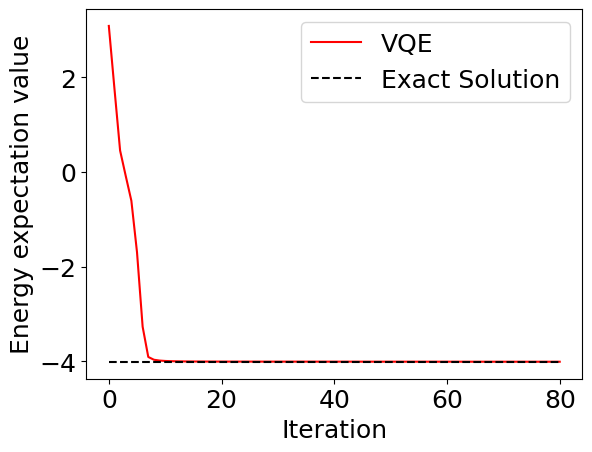

In [10]:
n_iters = 80

parameter_trajectory, losses = gradient_descent_optimizer(initial_parameters, loss_function, n_iters=n_iters, learning_rate=0.05)

final_parameters = parameter_trajectory[-1]

hamiltonian = get_ising_hamiltonian(n_qubits, transverse_field_coefficient)

gs_energy = np.min(qml.eigvals(hamiltonian, which='SR'))

plt.rcParams["font.size"] = 18
plt.plot(losses, color="red", label="VQE")
plt.plot(range(len(losses)), [gs_energy]*len(losses), linestyle="dashed", color="black", label="Exact Solution")
plt.xlabel("Iteration")
plt.ylabel("Energy expectation value")
plt.legend()
plt.show()


In [11]:
dloss = qml.grad(loss_function)

In [12]:
final_gradient = dloss(parameter_trajectory[-1])
final_gradient

array([ 1.10786718e-02,  1.35494638e-05,  7.45600776e-03,  8.85197665e-05,
        2.51156139e-03, -4.65509445e-03,  1.12550297e-04, -1.47203924e-03,
        1.51098912e-04,  1.04075506e-03,  6.03308716e-03,  3.38210326e-06,
        6.12603631e-03, -3.16251757e-05,  2.43746059e-04, -7.03700993e-03,
        8.00929347e-05, -3.00713611e-03,  8.65199122e-05,  7.42516583e-04,
        3.71767426e-03,  4.35383826e-06,  3.37583678e-03, -2.76960992e-05,
       -5.64066228e-04, -5.35571295e-03,  3.38340948e-05, -2.66383565e-03,
        1.74058519e-05,  4.64661660e-04,  2.72589251e-03, -1.33550643e-05,
        1.44422097e-03, -1.00175616e-05, -8.95941528e-04, -8.39258853e-03,
        6.42404758e-06, -3.82380741e-03, -1.80958013e-06,  8.69393532e-04,
        2.63788779e-04, -1.75138747e-05, -7.69552523e-04, -1.36537417e-05,
       -1.60382971e-03, -9.88867113e-03, -2.54744329e-05, -2.45008455e-03,
       -2.21548865e-05,  9.20856837e-05, -2.14386924e-03,  1.58376686e-05,
       -2.98007656e-03,  

In [17]:
ddloss = qml.jacobian(dloss)
final_hessian = ddloss(final_parameters)
final_hessian

array([[ 1.00174307e+00,  1.65688430e-05, -1.10114067e-06, ...,
        -8.12055289e-08, -2.30073664e-06,  8.55235932e-18],
       [ 1.65688430e-05,  2.00069051e+00, -2.30204782e-05, ...,
         2.25851056e-07,  5.55878620e-05, -4.12532342e-18],
       [-1.10114067e-06, -2.30204782e-05,  1.99880658e+00, ...,
         9.06767366e-02, -2.64625440e-06,  1.16467030e-20],
       ...,
       [-8.12055290e-08,  2.25851056e-07,  9.06767366e-02, ...,
         3.42825253e-03, -1.68435088e-16, -2.49176611e-16],
       [-2.30073664e-06,  5.55878620e-05, -2.64625440e-06, ...,
         2.04541463e-17,  4.99977951e-03, -4.29947231e-16],
       [ 9.01009336e-18, -1.46756389e-17,  1.33147965e-17, ...,
        -1.26705845e-16,  1.26973473e-16, -4.44764297e-16]])

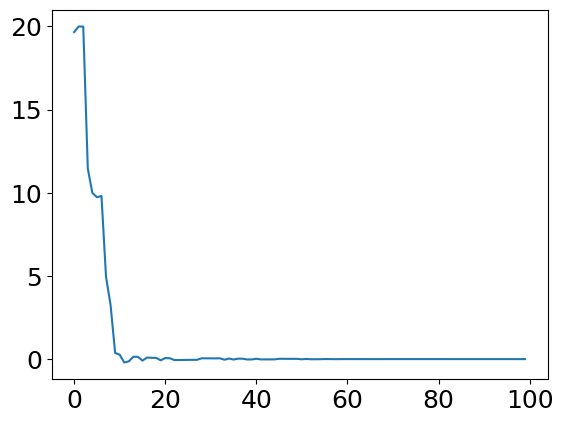

In [14]:
hessian_eigenvalues = np.linalg.eig(final_hessian)[0]

plt.plot(hessian_eigenvalues)

